In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import jaxttv, elements_to_pdic, params_to_elements
from jax.config import config
config.update('jax_enable_x64', True)
import jax, numpyro
#numpyro.set_host_device_count(4)
#print ('# jax device count:', jax.local_device_count())

In [3]:
d = pd.read_csv("v1298tau/ttv.txt", delim_whitespace=True, header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(4)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(4)]
p_init = [8.2438, 12.3960, 24.1315, 24.1315*2]

#%%
print (np.min(d.tc), np.max(d.tc))

2231.283312 4689.396172


In [4]:
dt = 0.2
t_start, t_end = 2230., 4700.
jttv = jaxttv(t_start, t_end, dt)

In [5]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs)

# integration starts at:           2230.00
# first transit time in data:      2231.28
# last transit time in data:       4689.40
# integration ends at:             4700.00
# integration time step:           0.2000 (1/41 of innermost period)


In [6]:
base = "v1298tau/dt0p2_jitter_"

initial objective function: 213812020.55 (46 data)

running LM optimization...
objective function: 195.25 (46 data)
# elapsed time (least square): 82.0 sec


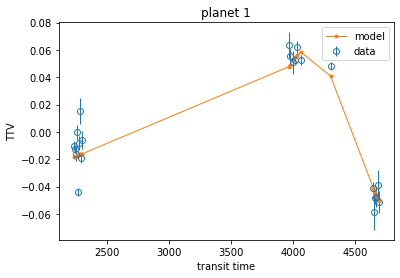

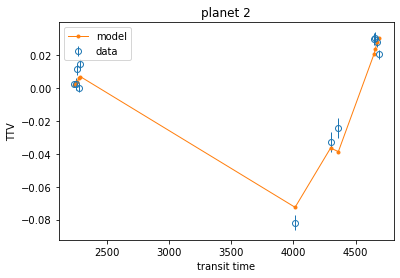

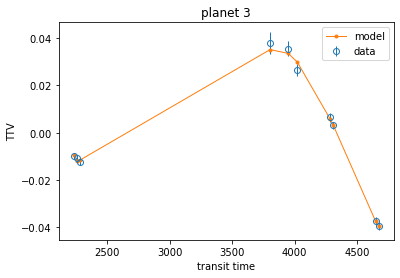

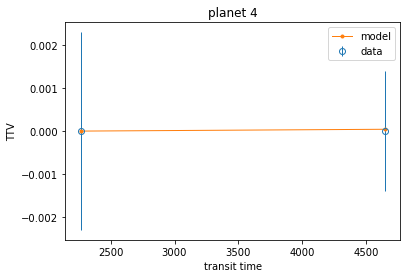

In [7]:
params_best = jttv.optim(amoeba=False, mmax=1e-4, emax=0.1)#, save=base+"ql")

In [8]:
tc, de = jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))
print (de)

1.479601970033606e-05


In [9]:
%timeit jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))

26.9 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
pdic = pd.DataFrame(elements_to_pdic(*params_to_elements(params_best, jttv.nplanet)))
print (pdic)

      pmass     period     ecosw     esinw  cosi  lnode          tic  \
0  0.982252   8.249594 -0.011549 -0.013672   0.0   -0.0  2231.274684   
1  1.624788  12.400829 -0.033881 -0.012963  -0.0   -0.0  2239.391476   
2  8.997618  24.140753 -0.099995 -0.009400  -0.0    0.0  2234.049673   
3  1.009559  48.586674  0.013283  0.014128  -0.0    0.0  2263.626340   

        ecc     omega     lnmass      mass      cosw      sinw  
0  0.017897 -2.272241 -12.733643  0.000003 -0.645322 -0.763911  
1  0.036277 -2.776168 -12.230359  0.000005 -0.933972 -0.357346  
2  0.100436 -3.047866 -10.518776  0.000027 -0.995611 -0.093590  
3  0.019391  0.816223 -12.706223  0.000003  0.684978  0.728564  


In [11]:
pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(p_init)
ones = jnp.ones_like(p_guess)

In [12]:
from numpyro.infer import init_to_value
import numpyro
import numpyro.distributions as dist
import jax.random as random

def model(dp=5e-1, dtic=1e-1, emax=0.5, mmin=1e-7, mmax=1e-3, uniform_mass=False):
    tic = numpyro.sample("tic", dist.Uniform(low=tic_guess-dtic, high=tic_guess+dtic))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-dp, high=p_guess+dp))
    ecc = numpyro.sample("ecc", dist.Uniform(low=ones*0, high=ones*emax))

    cosw = numpyro.sample("cosw", dist.Normal(scale=ones))
    sinw = numpyro.sample("sinw", dist.Normal(scale=ones))
    omega = jnp.arctan2(sinw, cosw)
    numpyro.deterministic("omega", omega)

    lnode = ones * 0
    numpyro.deterministic("lnode", lnode)
    cosi = ones * 0
    numpyro.deterministic("cosi", cosi)
    if uniform_mass:
        mass = numpyro.sample("mass", dist.Uniform(low=ones*mmin, high=ones*mmax))
        numpyro.deterministic("lnmass", jnp.log(mass))
    else:
        lnmass = numpyro.sample("lnmass", dist.Uniform(low=ones*jnp.log(mmin), high=ones*jnp.log(mmax)))
        mass = jnp.exp(lnmass)
        numpyro.deterministic("mass", mass)

    elements = jnp.array([period, ecc*cosw, ecc*sinw, cosi, lnode, tic]).T
    numpyro.deterministic("elements", elements)

    #tcmodel, ediff = jttv.get_ttvs_hermite4(elements, jnp.hstack([1, mass]))
    tcmodel, ediff = jttv.get_ttvs(elements, jnp.hstack([1., mass]))
    lntcjitter = numpyro.sample("lntcjitter", dist.Uniform(low=-8, high=-2))
    tcjitter = numpyro.deterministic("tcjitter", jnp.exp(lntcjitter))
    tcerrmodel = jnp.sqrt(jttv.errorobs_flatten**2 + tcjitter**2)
    #tcmodel = jnp.nan_to_num(tcmodel, nan=-jnp.inf)
    #ediff = jnp.nan_to_num(ediff, nan=jnp.inf)
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [13]:
pdic_init['lntcjitter'] = -4.8
init_strategy = init_to_value(values=pdic_init)
pdic_init

{'period': DeviceArray([ 8.24959407, 12.40082913, 24.14075307, 48.58667399], dtype=float64),
 'cosi': DeviceArray([ 0., -0., -0., -0.], dtype=float64),
 'lnode': DeviceArray([-0., -0.,  0.,  0.], dtype=float64),
 'tic': DeviceArray([2231.27468432, 2239.39147575, 2234.04967271, 2263.62633966],            dtype=float64),
 'ecc': DeviceArray([0.01789709, 0.03627652, 0.10043554, 0.01939135], dtype=float64),
 'lnmass': DeviceArray([-12.73364274, -12.23035854, -10.51877597, -12.70622265], dtype=float64),
 'mass': DeviceArray([2.95018481e-06, 4.88003319e-06, 2.70242495e-05,
              3.03219842e-06], dtype=float64),
 'cosw': DeviceArray([-0.64532163, -0.93397221, -0.99561086,  0.6849781 ], dtype=float64),
 'sinw': DeviceArray([-0.76391099, -0.35734566, -0.0935896 ,  0.72856365], dtype=float64),
 'lntcjitter': -4.8}

In [14]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.8, init_strategy=init_strategy)

In [15]:
nw, ns = 100, 100 # 7h40min
nw, ns = 250, 1000 # 65h

In [16]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)

In [17]:
import os, dill
posterior = base+"mcmc.pkl"
if os.path.exists(posterior):
    mcmc = dill.load(open(posterior, 'rb'))
else:
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, extra_fields=('potential_energy',), mmin=0, mmax=1e-4, uniform_mass=True)
    with open(base+"mcmc.pkl", "wb") as f:
        dill.dump(mcmc, f)

In [18]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     cosw[0]     -0.36      0.59     -0.31     -1.25      0.66    117.50      1.01
     cosw[1]     -0.07      0.52      0.02     -0.87      0.61     82.85      1.02
     cosw[2]      0.22      0.66      0.16     -1.04      1.22     52.77      1.03
     cosw[3]      0.09      0.69      0.05     -1.07      1.17     33.98      1.03
      ecc[0]      0.02      0.02      0.02      0.00      0.04     88.66      1.00
      ecc[1]      0.02      0.02      0.02      0.00      0.04     53.73      1.00
      ecc[2]      0.04      0.05      0.03      0.00      0.11     22.86      1.05
      ecc[3]      0.09      0.09      0.06      0.00      0.22     37.27      1.00
  lntcjitter     -4.74      0.16     -4.75     -5.05     -4.51    316.99      1.00
     mass[0]      0.00      0.00      0.00      0.00      0.00     24.03      1.05
     mass[1]      0.00      0.00      0.00      0.00      0.00     17.67      1.07
   

In [19]:
samples = mcmc.get_samples()

In [20]:
idx = samples['ediff']==samples['ediff']
np.sum(~idx)

0

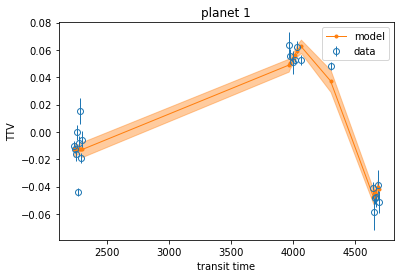

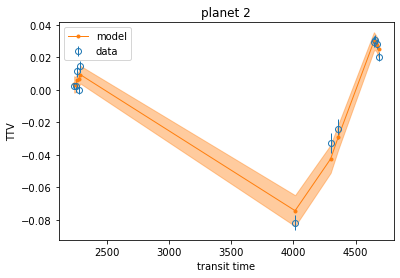

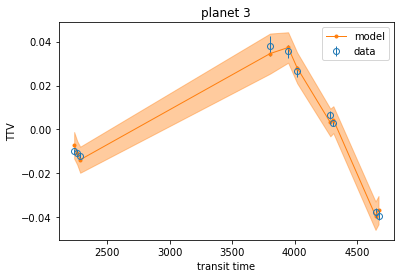

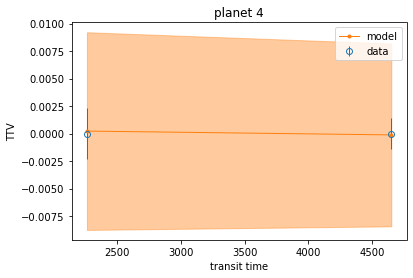

In [21]:
mmodel, smodel = jnp.mean(samples['tcmodel'], axis=0), jnp.std(samples['tcmodel'], axis=0)
jttv.quicklook(mmodel, sigma=smodel)#, save=base+"postm")

In [22]:
meanjit = jnp.exp(jnp.mean(samples['lntcjitter']))

planet 1 res std: 0.011516817185639794 res/raw err std: 2.7170316610742398 res/estimated err std: 1.0799162502078565
planet 2 res std: 0.004987417912064011 res/raw err std: 1.444277303068904 res/estimated err std: 0.5103612786233285
planet 3 res std: 0.002249288065657489 res/raw err std: 1.288754521366682 res/estimated err std: 0.24733729118445352
planet 4 res std: 0.00017426208296456025 res/raw err std: 0.09320305114512017 res/estimated err std: 0.01947765017512008


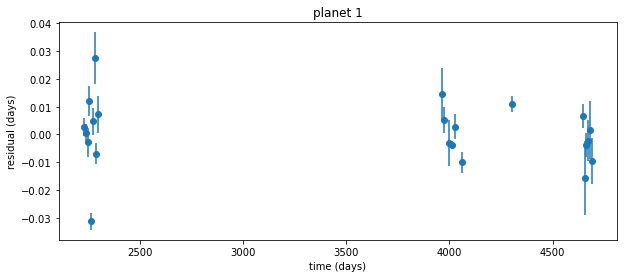

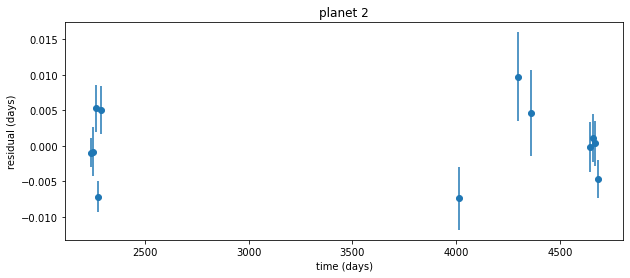

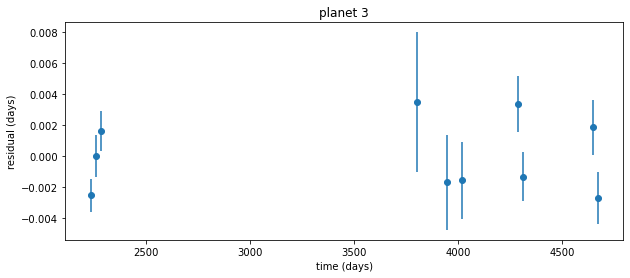

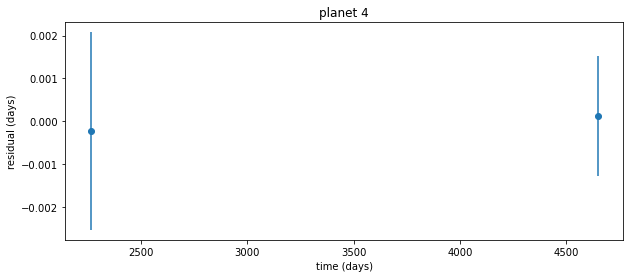

In [27]:
for j in range(4):
    plt.figure(figsize=(10,4))
    _idx = jttv.pidx==j+1
    res = jttv.tcobs_flatten[_idx]-mmodel[_idx]
    err0 = jttv.errorobs_flatten[_idx]
    err = np.sqrt(err0**2 + meanjit**2)
    print ("planet", j+1, "res std:", np.std(res), "res/raw err std:", np.std(res/err0), 
           "res/estimated err std:", np.std(res/err))
    #plt.errorbar(jttv.tcobs_flatten[_idx], res/jttv.errorobs_flatten[_idx], fmt='o')
    plt.errorbar(jttv.tcobs_flatten[_idx], res, yerr=jttv.errorobs_flatten[_idx], fmt='o')
    plt.title("planet %d"%(j+1))
    plt.xlabel("time (days)")
    plt.ylabel('residual (days)')

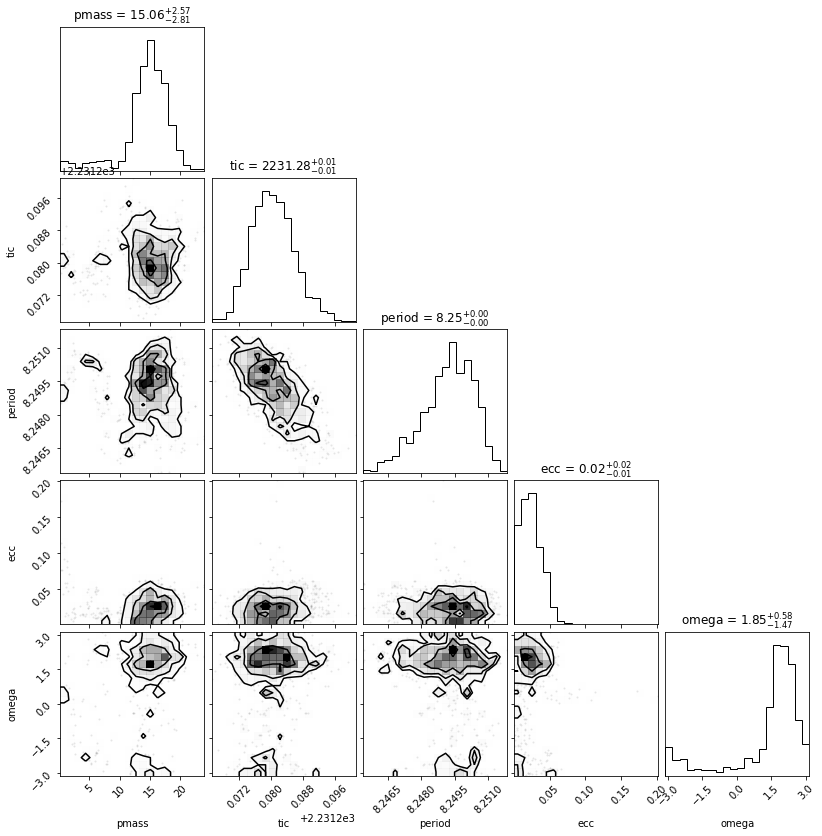

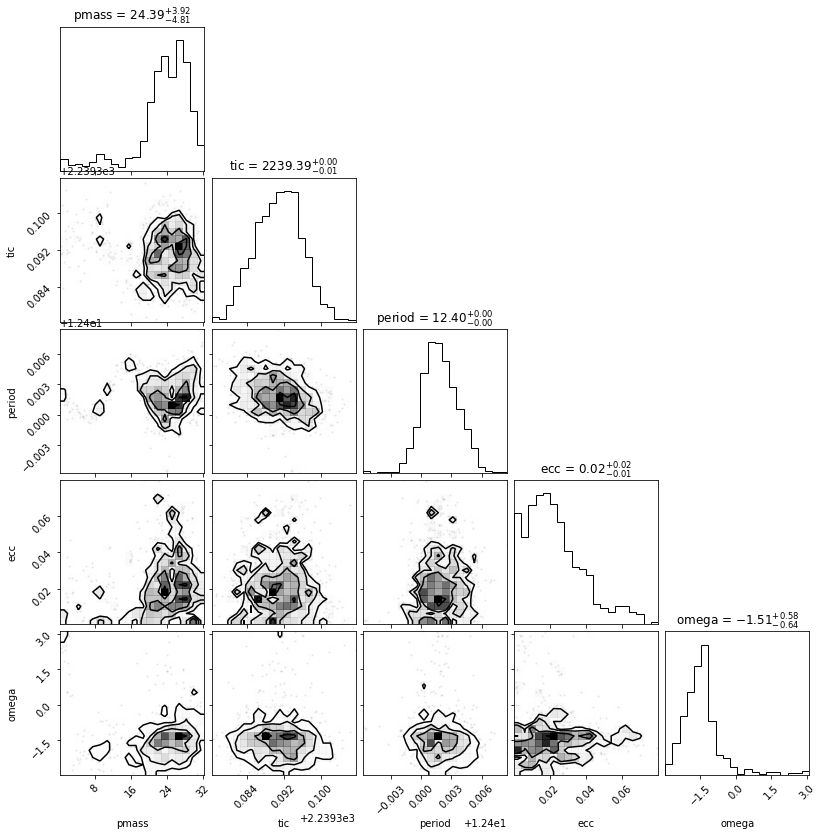

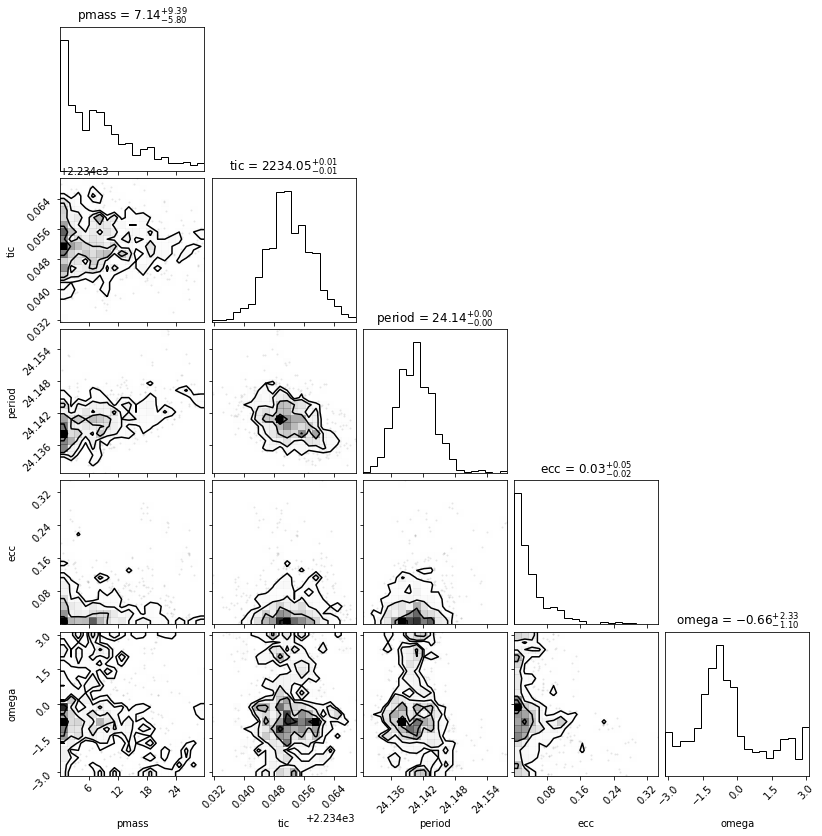

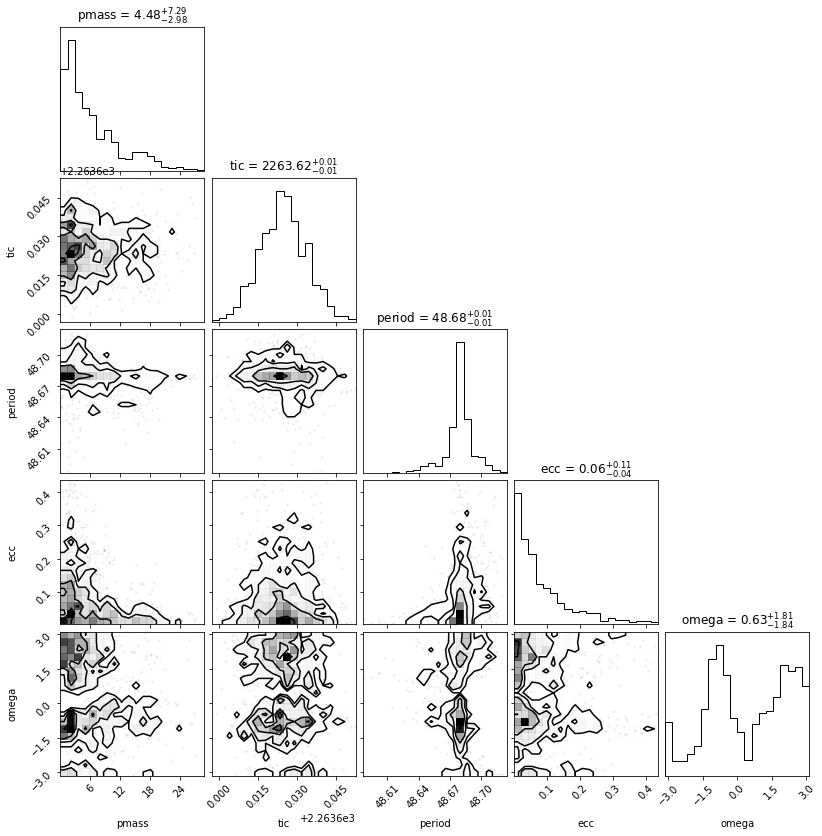

In [28]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']
#keys = ['lnmass', 'tic', 'period', 'ecc', 'omega']

for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    fig = corner.corner(hyper, labels=keys, show_titles="%.2f")
    #plt.savefig(base+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight")

In [29]:
jttv2 = jaxttv(t_start, t_end, dt / 10.)
jttv2.set_tcobs(tcobs, p_init, errorobs=errorobs)

# integration starts at:           2230.00
# first transit time in data:      2231.28
# last transit time in data:       4689.40
# integration ends at:             4700.00
# integration time step:           0.0200 (1/412 of innermost period)


In [30]:
k = 100

In [31]:
tc1, ediff1 = jttv2.get_ttvs(samples['elements'][k], jnp.hstack([1., samples['mass'][k]]))

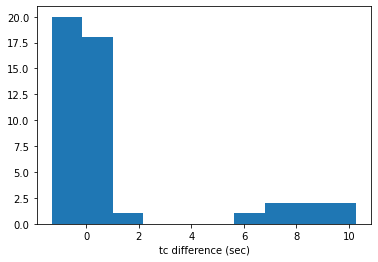

In [32]:
plt.xlabel("tc difference (sec)")
plt.hist(np.array(samples['tcmodel'][k] - tc1)*86400.);